In [94]:
import pydotplus 
import pandas as pd

from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
%matplotlib inline

## Задание 1

In [53]:
data = pd.read_csv("german.data-numeric", sep="\\s+", header=None)

In [54]:
columns = [i for i in range(25)]
columns[0] = "Status of existing checking account"
columns[1] = "Duration in month"
columns[2] = "Credit history"
columns[4] = "Savings account/bonds"
columns[5] = "Present employment since"
columns[6] = "Personal status and sex"
columns[7] = "Present residence since"
columns[8] = "Property"
columns[9] = "Age in years"
columns[10] = "Other installment plans"
columns[11] = "Existing credits at bank"
columns[12] = "Number of people liable to provide maintenance for"
columns[24] = "Accepted"
data.columns = columns
target = data["Accepted"]
del data["Accepted"]

In [55]:
data.head()

,Status of existing checking account,Duration in month,Credit history,3,Savings account/bonds,Present employment since,Personal status and sex,Present residence since,Property,Age in years,...,14,15,16,17,18,19,20,21,22,23
0,1,6,4,12,5,5,3,4,1,67,...,1,0,0,1,0,0,1,0,0,1
1,2,48,2,60,1,3,2,2,1,22,...,1,0,0,1,0,0,1,0,0,1
2,4,12,4,21,1,4,3,3,1,49,...,1,0,0,1,0,0,1,0,1,0
3,1,42,2,79,1,4,3,4,2,45,...,1,0,0,0,0,0,0,0,0,1
4,1,24,3,49,1,3,3,4,4,53,...,1,1,0,1,0,0,0,0,0,1


In [80]:
target_names=["Accept", "Reject"]

In [57]:
target.head()

0    1
1    2
2    1
3    1
4    2
Name: Accepted, dtype: int64

In [61]:
Counter(target)

Counter({1: 700, 2: 300})

Сделаем oversampling

In [65]:
X, y = RandomOverSampler().fit_sample(data, target)

In [68]:
Counter(y)

Counter({1: 700, 2: 700})

In [69]:
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size = 0.3)

Построим маленькое решающее дерево и посмотрим на первые разбиения.

In [75]:
model = tree.DecisionTreeClassifier(max_depth=4)

In [76]:
model.fit(train_data, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

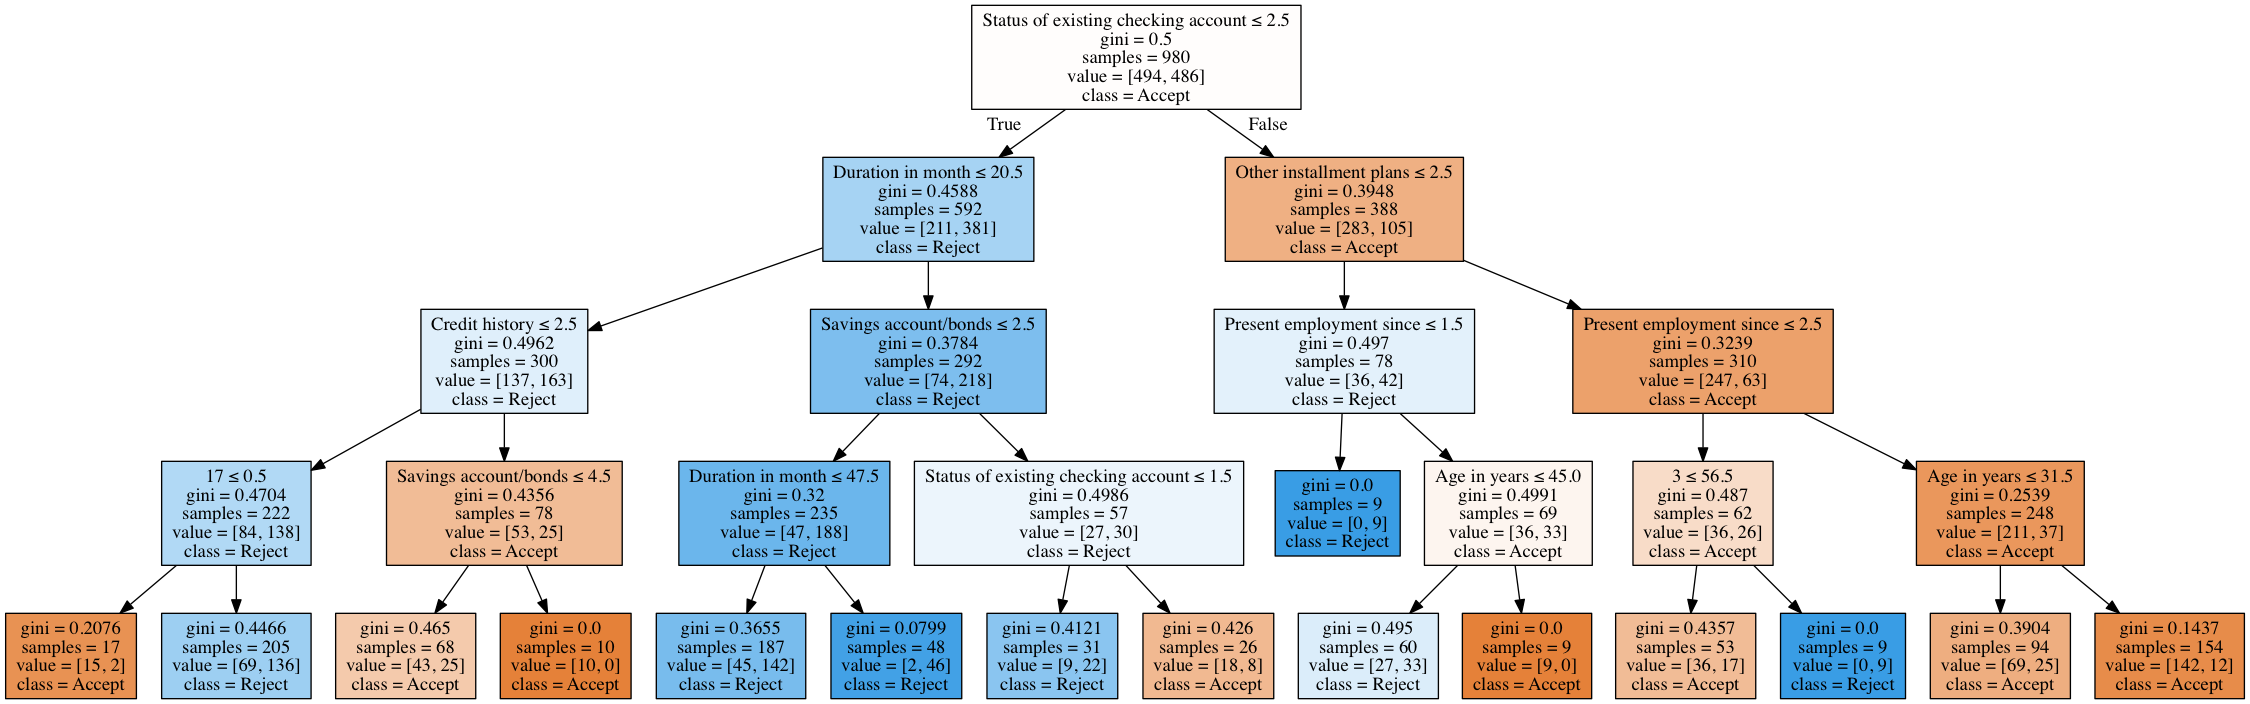

In [81]:
dot_data = tree.export_graphviz(model, out_file="german_tree.out", 
                         feature_names=data.keys(),  
                         class_names=target_names,  
                         filled=True, rounded=False,  
                         special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("german_tree.out")  
Image(graph.create_png())

Сразу видно логику: например, самое первое разбиение уже разбивает выборку, среди тех, у кого checking account существует уже > 2.5 года, больше Accept, что логично. Также можно обратить внимание на credi history, если она маленькая, то Reject - объекты доминируют, что тоже логично, чем хуже кредитная история, тем менее вероятнее челвоеку дадут кредит. Можно посмотреть на Age in years <= 45.0, молодым людям реже дают кредиты, т.к. у них зачастую нет хорошей работы.

Построим граффик качества от глубины.

In [102]:
acc = [np.mean(cross_val_score(tree.DecisionTreeClassifier(max_depth=depth),
                               X, y)) for depth in np.arange(1, 100)]

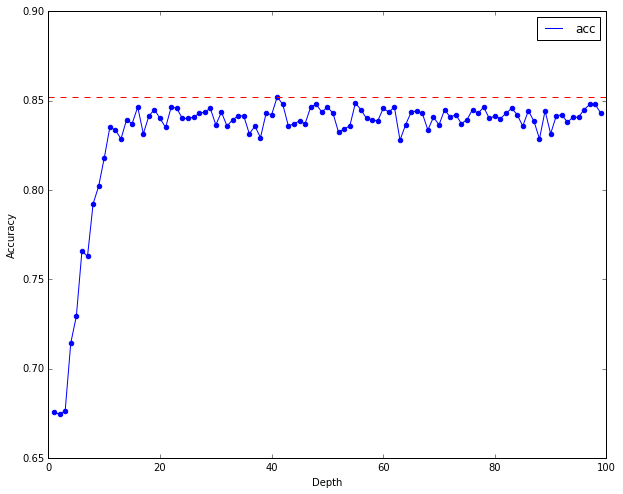

In [110]:
plt.figure(figsize=(10, 8))
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.xlim((0,100))
plt.plot(np.arange(1, 100), acc, color="blue", label="acc")
plt.scatter(np.arange(1, 100), acc, color="blue", s=20)
plt.axhline(max(acc), ls = '--', color="red")
plt.legend(loc="best")
plt.show()

На определённой глубине прекращается прирост, поэтому разумно где-то на 18 прекратить наращивать глубину.